In [1]:
# Decompress a required file
!unzip -o ../data/vegashrinker.zip -d ../data

Archive:  ../data/vegashrinker.zip
  inflating: ../data/vegashrinker.csv  


In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter("ignore")

# Specify datafile
data_file = os.path.join('..', 'data', 'vegashrinker.csv')

# Component Wear Anomalies

## Skinwrapper Machines

**Let's consider the Vega skinwrapper family of packaging machines by [OCME](https://www.ocme.com/en?_ptc=4)**


* They work by wrapping products (bottles) in a _plastic film_
* ...Which is _cut and heated_, so that the film shrinks and stabilizes the content

<center><img src="assets/vega-skinwrapper.jpeg" width="70%"/></center>

## OCME Vega Shrinker

**A public dataset for a skinwrapper is [available from Kaggle](https://www.kaggle.com/inIT-OWL/one-year-industrial-component-degradation)**

* The dataset contains _a single run-to-failure experiment_
* I.e. the machine was left running until its blade became unusable

**This is an example of anomaly _due to component wear_**

* It's a common type of anomaly
* ...And run-to-failure experiments are a typical way to investigate them

**All problems in this class share a few _properties_**

* There is a critical anomaly _at the end of the experiment_
* The behavior becomes _more and more distant_ from normal over time

...Meaning that they are good fit for many of the techniques we have studied

## The Dataset

**Let's have a first look at the dataset**

In [4]:
data = pd.read_csv(data_file)
data

,mode,segment,smonth,sday,stime,timestamp,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed
0,1,0,1,4,184148,0.008000,0.199603,0.027420,628392628,-920.104980,5298555,2441.235352,0.899543,1379.999756
1,1,0,1,4,184148,0.012000,0.281624,0.002502,628392625,-937.271118,5298565,2453.819092,0.874072,1379.999756
2,1,0,1,4,184148,0.016000,0.349315,-0.018085,628392621,-951.004028,5298575,2476.469727,0.879806,1379.999756
3,1,0,1,4,184148,0.020000,0.444450,-0.054680,628392617,-1019.668579,5298585,2501.637207,0.837500,1379.999756
4,1,0,1,4,184148,0.024000,0.480923,-0.042770,628392613,-1023.101807,5298595,2519.254395,0.905347,1379.999756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062907,2,518,12,28,185909,8.179999,-0.277697,-0.023948,194924473,7220.077148,11693928,4610.663086,0.958136,1499.999756
1062908,2,518,12,28,185909,8.183999,-0.285098,-0.022138,194924502,7257.842773,11693946,4618.213379,0.971821,1499.999756
1062909,2,518,12,28,185909,8.187999,-0.155192,-0.034412,194924531,7371.139160,11693964,4582.979004,0.981734,1499.999756
1062910,2,518,12,28,185909,8.191999,-0.371426,0.031594,194924560,7360.839844,11693983,4615.696777,0.987367,1499.999756


* The data refers to disjoint measurement windows
* Each segment contains data sampled _every 4ms_

## The Dataset

**Let's check some statistics**

In [5]:
data.describe()

,mode,segment,smonth,sday,stime,timestamp,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed
count,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06
mean,2.323699e+00,2.590000e+02,5.271676e+00,1.654143e+01,1.362122e+05,4.102069e+00,-1.206338e-01,-5.472746e-05,3.371415e+08,1.945795e+03,1.488169e+08,5.367032e+03,9.847591e-01,1.927328e+03
std,1.649207e+00,1.498222e+02,3.505212e+00,8.490150e+00,3.226381e+04,2.364827e+00,6.078708e-01,1.212122e-01,5.466868e+08,4.873922e+03,2.711355e+08,3.382194e+03,3.437204e-01,6.559047e+02
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,8.115800e+04,4.000000e-03,-6.560303e+00,-1.888258e+00,-2.039056e+09,-9.482574e+03,1.936250e+05,-2.013385e+01,-9.143658e-01,0.000000e+00
25%,1.000000e+00,1.290000e+02,2.000000e+00,9.000000e+00,1.113170e+05,2.056000e+00,-3.696310e-01,-2.201461e-02,8.626082e+07,-1.908875e+03,2.136702e+07,3.032669e+03,8.384416e-01,1.500000e+03
50%,2.000000e+00,2.590000e+02,4.000000e+00,1.800000e+01,1.348180e+05,4.104000e+00,-1.187128e-01,6.456900e-04,1.919407e+08,2.595520e+03,7.259557e+07,4.582979e+03,9.711797e-01,1.800000e+03
75%,3.000000e+00,3.890000e+02,8.000000e+00,2.300000e+01,1.618270e+05,6.152000e+00,2.546913e-01,2.380830e-02,5.691639e+08,5.441666e+03,1.602507e+08,5.823731e+03,1.105926e+00,2.280000e+03
max,8.000000e+00,5.180000e+02,1.200000e+01,3.100000e+01,2.232490e+05,8.199999e+00,3.856873e+00,2.021531e+00,1.911789e+09,1.792831e+04,1.453671e+09,1.797202e+04,3.567880e+00,3.600000e+03


* The data is neither normalized nor standardized

## Missing Values

**Let's check for missing values in the columns related to sensor readings**

In [6]:
data.isnull().any()

mode                                                    False
segment                                                 False
smonth                                                  False
sday                                                    False
stime                                                   False
timestamp                                               False
pCut::Motor_Torque                                      False
pCut::CTRL_Position_controller::Lag_error               False
pCut::CTRL_Position_controller::Actual_position         False
pCut::CTRL_Position_controller::Actual_speed            False
pSvolFilm::CTRL_Position_controller::Actual_position    False
pSvolFilm::CTRL_Position_controller::Actual_speed       False
pSvolFilm::CTRL_Position_controller::Lag_error          False
pSpintor::VAX_speed                                     False
dtype: bool

No missing value in the dataset

## Acquisition Windows

**And let's check the length of each segment**

In [7]:
data.groupby('segment')['mode'].count().describe()

count     519.0
mean     2048.0
std         0.0
min      2048.0
25%      2048.0
50%      2048.0
75%      2048.0
max      2048.0
Name: mode, dtype: float64

* There are 519 segments overall
* ...Each with 2048 samples

## Input Columns

**Let's have a look at all non-time related columns**

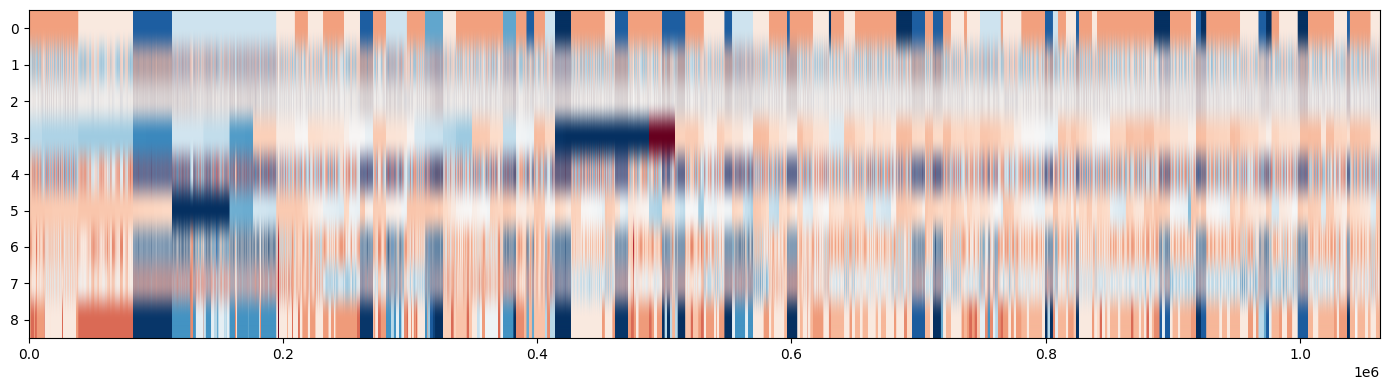

In [8]:
feat_in = data.columns[[0, 6, 7, 8, 9, 10, 11, 12, 13]]
data2 = data[feat_in].copy()
util.plot_dataframe((data2 - data2.mean()) / data2.std(), figsize=figsize)

* A few features (row 0, 2, 3, 5, 8) have very "suspicious" behavior

## Input Columns

**Column 0 corresponds to an _operating mode_**

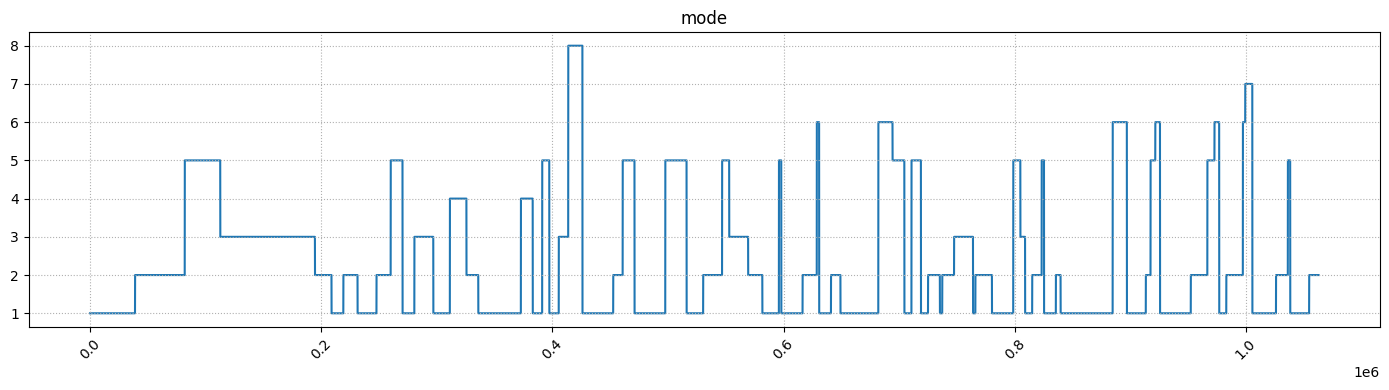

In [9]:
util.plot_series(data2[data2.columns[0]], figsize=figsize, title=data2.columns[0])

* The mode is _a controlled parameter_ and does not change in the middle of a segment
* Intuitively, the mode _has an impact_ on the machine behavior

## Input Columns

**Column 8 is also a fixed over long periods of time**

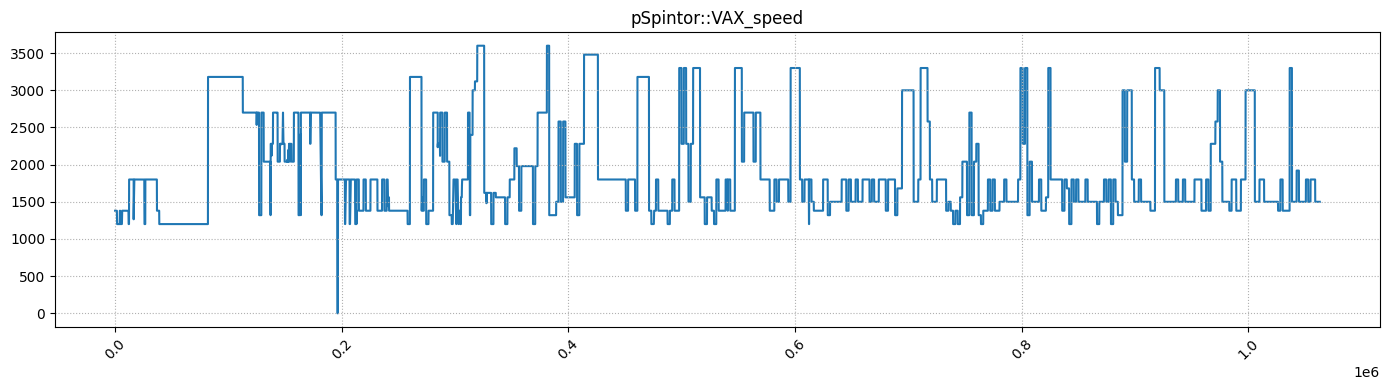

In [10]:
util.plot_series(data2[data2.columns[8]], figsize=figsize, title=data2.columns[8])

* This is _likely_ a controlled parameter
* Ideally, we would speak with the customer (but in this excercise we can't)

## Input Columns

**Column 2 peaks repeatedly over _short time periods_**

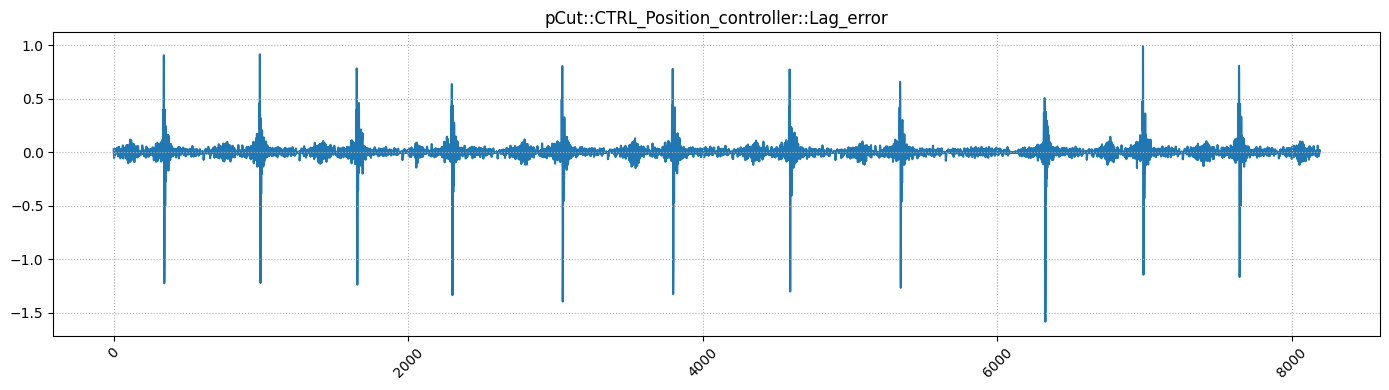

In [11]:
util.plot_series(data2[data2.columns[2]].iloc[:2048*4], figsize=figsize, title=data2.columns[2])

* There is nothing really wrong with this
* ...And it explains the mostly white row in our previous plot

## Input Columns

**Column 3 contains an odd, localized, deviation**

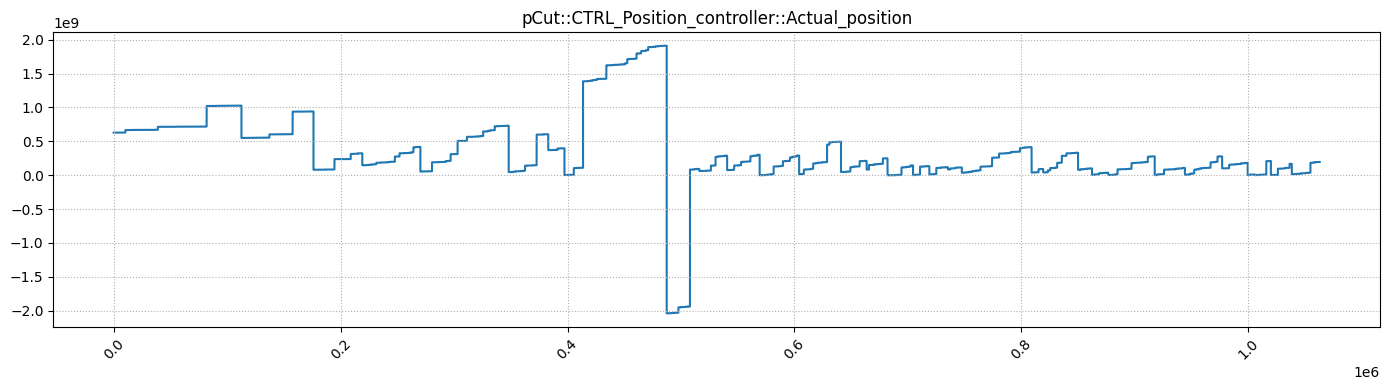

In [12]:
util.plot_series(data2[data2.columns[3]], figsize=figsize, title=data2.columns[3])

* This is likely the result of manual adjustment
* We'd better keep this column off

## Input Columns

**...And the same holds for column 5**

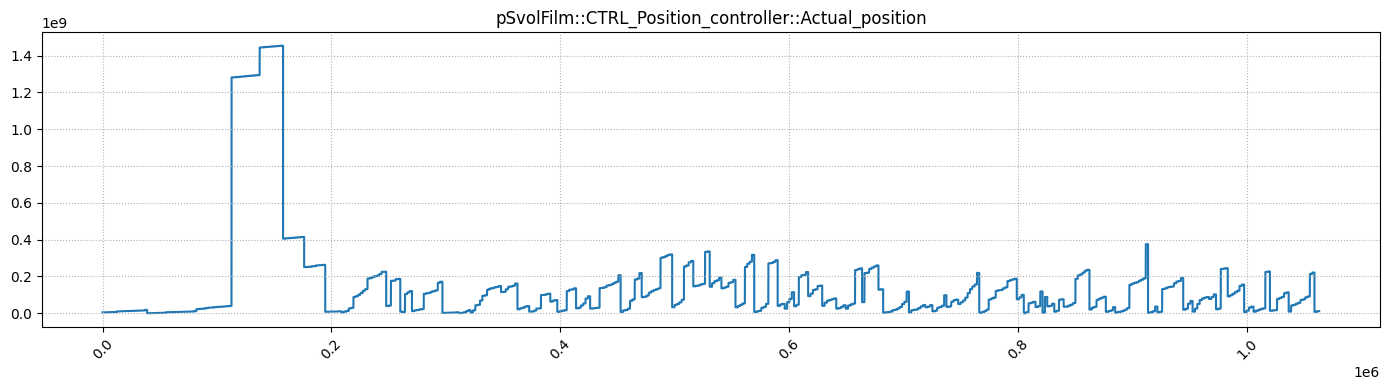

In [13]:
util.plot_series(data2[data2.columns[5]], figsize=figsize, title=data2.columns[5])

* Again, this is probably the a mistake, or due to human intervention
* We'd better keep this column off

# Data Preparation

## Binning

**This dataset contain _high-frequency data_ (4ms sampling period)**

* In this situation, feeding the raw data to a model does not usually make sense
* So we will use subsampling

**A binning approach typically works as follows:**

We apply a sliding window, but so that its consecutive applications _do not overlap_

* Each window application is called a _bin_
* ...From which we extract one or more _features_
* ...By applying different _aggregation functions_

**The result is series that contains a _smaller number of samples_**

...But typically a _larger number of features_

## Binning

**We will apply binning to all columns not related to time**

...Except for the two we chose to discard

In [14]:
feat_in_r = data2.columns[[0, 1, 2, 4, 6, 7, 8]]
print(list(feat_in_r))

['mode', 'pCut::Motor_Torque', 'pCut::CTRL_Position_controller::Lag_error', 'pCut::CTRL_Position_controller::Actual_speed', 'pSvolFilm::CTRL_Position_controller::Actual_speed', 'pSvolFilm::CTRL_Position_controller::Lag_error', 'pSpintor::VAX_speed']


**First, we define which aggregation function to apply to each field**

In [15]:
aggmap = {a: ['mean', 'std', 'skew'] for a in feat_in_r}
aggmap['mode'] = 'first'
aggmap['pSpintor::VAX_speed'] = 'first'

* For the features that are fixed over a segment, we pick the first value

## Binning

**Then we build out bins**

In [16]:
binsize = 512 # 2 seconds of measurements
bins = []
for sname, sdata in data.groupby('segment'):
    sdata['bin'] = sdata.index // binsize # Build the bin numbers
    tmp = sdata.groupby('bin').agg(aggmap) # Apply the aggregation functions
    bins.append(tmp)
data_b = pd.concat(bins)

* We process each segment individually
* ...So that we are sure that no bin overlaps two segments

**We chose our bin size based on:**

* Having enough data to compensate noise
* Capture regular patterns (e.g. our spiking signal)

## Binning

**Let's inspect the result**

In [17]:
data_b

mode pCut::Motor_Torque                      \
     first               mean       std      skew   
bin                                                 
0        1          -0.125718  0.544329 -2.488922   
1        1          -0.072671  0.540906 -2.635165   
2        1           0.014070  0.354287  0.152579   
3        1          -0.207667  0.455206 -3.803152   
4        1          -0.289142  0.434465 -4.372388   
...    ...                ...       ...       ...   
2071     2          -0.184381  0.781750 -3.758458   
2072     2          -0.207829  0.791797 -3.968010   
2073     2          -0.146367  0.846064 -3.683229   
2074     2          -0.125521  0.800829 -3.798401   
2075     2           0.032077  0.349737 -0.137235   

     pCut::CTRL_Position_controller::Lag_error                      \
                                          mean       std      skew   
bin                                                                  
0                                    -0.000167  0.110956 -3.746651   
1                                    -0.000567  0.103435 -3.336454   
2                                     0.000724  0.031961  0.032216   
3                                    -0.000150  0.103125 -4.496910   
4                                    -0.000275  0.106193 -5.242337   
...                                        ...       ...       ...   
2071                                  0.000508  0.116385 -1.459755   
2072                                 -0.000285  0.115259 -1.482473   
2073                                 -0.001013  0.116217 -1.488226   
2074                                 -0.001139  0.117804 -1.245373   
2075                                 -0.000274  0.034452 -0.078601   

     pCut::CTRL_Position_controller::Actual_speed                         \
                                             mean          std      skew   
bin                                                                        
0                                     1599.917513  3999.045185 -0.209394   
1                                      844.540436  3862.165458  0.309415   
2                                       60.570994  2816.788446 -0.245380   
3                                     2670.353585  2474.506197  0.155697   
4                                     2579.037789  2626.919219 -0.502959   
...                                           ...          ...       ...   
2071                                  1819.838542  4007.857890 -0.029032   
2072                                  1936.977300  3932.533837 -0.082154   
2073                                  1556.298091  4088.929784  0.137784   
2074                                  1148.293884  3980.947227  0.422832   
2075                                   493.331985  3127.137947  0.204754   

     pSvolFilm::CTRL_Position_controller::Actual_speed                         \
                                                  mean          std      skew   
bin                                                                             
0                                          3709.587834   972.901859 -0.413521   
1                                          3690.766286   988.030036 -0.405081   
2                                          3202.037644  1030.350427  0.506602   
3                                          2622.779851   917.804858  1.323136   
4                                          3024.627191   917.469344 -0.013722   
...                                                ...          ...       ...   
2071                                       3692.039403   917.166958 -0.215009   
2072                                       3691.149689   917.226790 -0.215622   
2073                                       3690.761287   917.441935 -0.214397   
2074                                       3660.678499   942.956595 -0.188799   
2075                                       3397.084636   950.222864  0.374966   

     pSvolFilm::CTRL_Position_controller::Lag_error                      \
       

* We have much fewer rows, and more columns